In [26]:
from skfolio.optimization import MeanRisk
from skfolio.moments import EmpiricalCovariance, LedoitWolf
from skfolio import RiskMeasure
from skfolio.prior import EmpiricalPrior
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Data Processing

In [13]:
fx_raw = pd.read_csv("FX_rates.csv")

currency_row = fx_raw.iloc[0, 1:].values
fx = fx_raw.iloc[1:].copy()
fx["Time Period"] = pd.PeriodIndex(fx["Time Period"], freq="M")
fx = fx.set_index("Time Period")
fx = fx.apply(pd.to_numeric, errors="coerce")


fx_adj = fx.copy()
for col, curr in zip(fx.columns, currency_row):
    if curr != "USD":
        fx_adj[col] = 1.0 / fx_adj[col]

delta_s = np.log(fx_adj).diff().dropna(how="all").round(6)

rf_raw = pd.read_csv("Risk Free Rates.csv")
currency_to_country = {
    "USD": "USD",
    "AUD": "AUSTRALIA", "CAD": "CANADA", "EUR": "EURO AREA",
    "BRL": "BRAZIL", "CHF": "SWITZERLAND", "DKK": "DENMARK",
    "GBP": "UNITED KINGDOM", "JPY": "JAPAN", "KRW": "KOREA",
    "ZAR": "SOUTH AFRICA", "TWD": "TAIWAN", "SGD": "SINGAPORE",
    "NZD": "NEW ZEALAND", "MXN": "MEXICO", "NOK": "NORWAY",
    "INR": "INDIA", "CNY": "CHINA", "SEK": "SWEDEN"
}
rf = rf_raw.rename(columns=currency_to_country)

fx_countries = delta_s.columns
for country in fx_countries:
    if country not in rf.columns:
        rf[country] = np.nan

rf["Time Period"] = pd.to_datetime(rf["Time Period"], format="%Y%m%d", errors='coerce')
rf = rf.set_index("Time Period")
rf = rf.apply(pd.to_numeric, errors="coerce")

rf_monthly = rf.resample('ME').mean().round(6)
rf_monthly.index = rf_monthly.index.to_period("M")


common_index = delta_s.index.intersection(rf_monthly.index)
delta_s = delta_s.loc[common_index]
rf_monthly = rf_monthly.loc[common_index]

usd_rf = rf_monthly["USD"]

excess_returns = pd.DataFrame(index=common_index, columns=delta_s.columns, dtype=float)

for col in delta_s.columns:
    if col not in rf_monthly.columns:
        continue

    mask = delta_s[col].notna() & rf_monthly[col].notna() & usd_rf.notna()
    excess_returns.loc[mask, col] = rf_monthly.loc[mask, col] - usd_rf.loc[mask] - delta_s.loc[mask, col]

excess_returns.round(6).drop(["INDIA", "CHINA", "KOREA"], axis=1).to_csv("FX_excess_returns.csv", na_rep="NaN")

In [14]:
df = pd.read_csv("FX_excess_returns.csv")

df["Time Period"] = pd.to_datetime(df["Time Period"])
df = df.set_index("Time Period")

returns = df.astype(float)

### Rolling-window out-of-sample framework

In [15]:
WINDOW = 60  # rolling window length (5 years)
n_assets = returns.shape[1]
assets = returns.columns

rf = pd.Series(0.0, index=returns.index)

oos_returns = {
    "Markowitz": [],
    "EqualWeight": [],
    "Shrinkage": [],
    "Constrained": [],
    "Resampled": []
}

oos_dates = []

population_all = None

### In-sample benchmark: Tangency portfolio (Markowitz)

In [16]:
mu_hat = returns.mean().values
Sigma_hat = EmpiricalCovariance().fit(returns.values).covariance_

inv_Sigma = np.linalg.inv(Sigma_hat)
ones = np.ones(n_assets)

w_is = inv_Sigma @ mu_hat / (ones @ inv_Sigma @ mu_hat)

benchmark_weights = pd.Series(w_is, index=assets)
# print(benchmark_weights)

### Optimization Methods

In [17]:
for t in range(WINDOW, len(returns) - 1):

    train = returns.iloc[t-WINDOW:t]
    test = returns.iloc[t+1]
    oos_dates.append(returns.index[t])

    #### SAMPLE MARKOWITZ ####
    mv = MeanRisk(
        risk_measure=RiskMeasure.VARIANCE
    )
    # Population for frontier
    mv.fit(train.values)
    w_mv = mv.weights_

    oos_returns["Markowitz"].append(np.dot(w_mv, test.values))

    #### NAIVE EQUAL WEIGHT 1/N ####
    w_eq = np.ones(n_assets) / n_assets
    oos_returns["EqualWeight"] = oos_returns.get("EqualWeight", [])
    oos_returns["EqualWeight"].append(np.dot(w_eq, test.values))

    ### LEDOIT-WOLD SHRINKAGE ####
    mv_shrink = MeanRisk(
        risk_measure=RiskMeasure.VARIANCE,
        prior_estimator=EmpiricalPrior(covariance_estimator=LedoitWolf())
    )
    mv_shrink.fit(train.values)
    w_shrink = mv_shrink.weights_
    oos_returns["Shrinkage"].append(np.dot(w_shrink, test.values))

    #### CONSTRAINED MARKOWITZ ####
    mv_const = MeanRisk(
        risk_measure=RiskMeasure.VARIANCE,
        min_weights=0.0,
        max_weights=0.20
    )

    mv_const.fit(train.values)
    w_const = mv_const.weights_
    oos_returns["Constrained"].append(np.dot(w_const, test.values))

    #### MICHAUD RESAMPLING ####
    B = 60
    weights_boot = np.zeros((B, n_assets))

    for b in range(B):

        idx = np.random.choice(WINDOW, size=WINDOW, replace=True)
        boot_sample = train.iloc[idx]

        mv_boot = MeanRisk(
            risk_measure=RiskMeasure.VARIANCE
        )

        mv_boot.fit(boot_sample.values)
        weights_boot[b, :] = mv_boot.weights_

    # Average WEIGHTS (not returns)
    w_resampled = weights_boot.mean(axis=0)

    oos_returns["Resampled"].append(
        np.dot(w_resampled, test.values)
    )

#### Convert out-of-sample returns to DataFrame

In [31]:
oos_df = pd.DataFrame(oos_returns, index=oos_dates)
oos_df.to_csv("oos_returns.csv", index=True)

#### Sharpe ratios

In [32]:
sharpe_results = {}

for col in oos_df.columns:
    excess = oos_df[col] - rf.loc[oos_df.index]
    sharpe_results[col] = excess.mean() / excess.std()

#### Final results table (benchmarking)

In [ ]:
sharpe_table = (
    oos_df.mean() / oos_df.std()
).to_frame("Out-of-Sample Sharpe Ratio") \
 .sort_values(by="Out-of-Sample Sharpe Ratio", ascending=False)

sharpe_table

### Plots

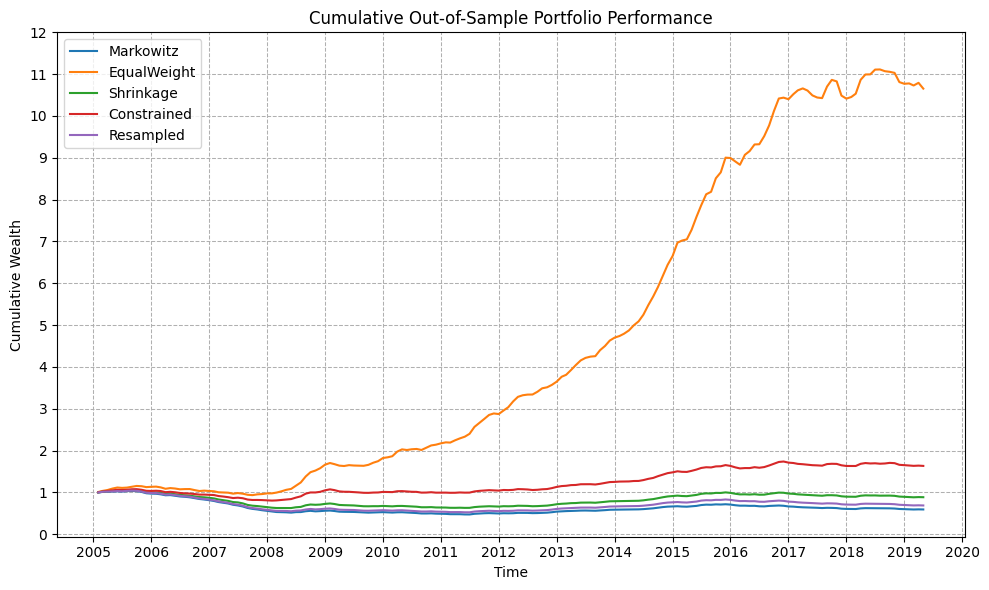

In [35]:
cum_returns = (1 + oos_df).cumprod()

plt.figure(figsize=(10, 6))
for col in cum_returns.columns:
    plt.plot(cum_returns.index, cum_returns[col], label=col)

plt.legend()
plt.title("Cumulative Out-of-Sample Portfolio Performance")
plt.xlabel("Time")
plt.ylabel("Cumulative Wealth")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
y_max = int(cum_returns.max().max()) + 1  # get max across all columns
plt.yticks(range(0, y_max + 1, 1))
plt.tight_layout()
plt.grid(True,linestyle='--',linewidth=0.75)
plt.show()

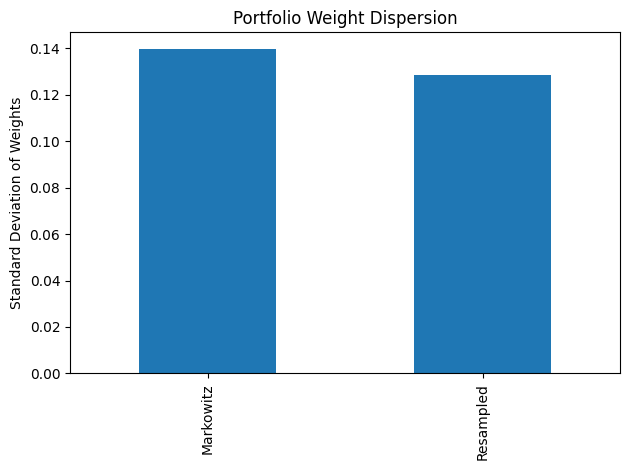

In [36]:
pd.DataFrame({
    "Markowitz": np.std(w_mv),
    "Resampled": np.std(w_resampled)
}, index=["Weight Dispersion"]).T.plot(
    kind="bar",
    legend=False,
    title="Portfolio Weight Dispersion"
)

plt.ylabel("Standard Deviation of Weights")
plt.tight_layout()
plt.show()